# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

In [ ]:
from keras.backend import clear_session
clear_session()
%reload_ext tensorboard

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import random
import librosa
import librosa.display
import tensorflow as tf
import torchaudio
import torchvision
from torchvision import models, transforms
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report,confusion_matrix
import itertools

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [5]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} 
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]

In [6]:
# Die Trainigschleife
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim = 1)[1], targets)#.view(2)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
#Die optimale Lernrate finden        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses        

In [7]:
# Audiodateien
PATH_TO_RAVDESS = Path.cwd() / "ravdess" / "frequenzbereich"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS / "train"
PATH_RAVDESS_TEST = PATH_TO_RAVDESS / "test"
PATH_RAVDESS_VALID = PATH_TO_RAVDESS / "valid"

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [8]:
# Das Einlesen der Bilder
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [9]:
def LoadRavdess(bs):

    ravdess_train = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )

    ravdess_test = PrecomputedRavdess(PATH_RAVDESS_TEST,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )
    
    ravdess_valid = PrecomputedRavdess(PATH_RAVDESS_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
    )

    ravdess_train_loader = torch.utils.data.DataLoader(ravdess_train, bs, shuffle=True)
    ravdess_test_loader = torch.utils.data.DataLoader(ravdess_test, bs, shuffle=True)
    ravdess_valid_loader = torch.utils.data.DataLoader(ravdess_valid, bs, shuffle=True)
            
    return ravdess_train_loader, ravdess_test_loader, ravdess_valid_loader 

### Die Datenvisualisierung<a class="anchor" id="#datenvisual"></a>

In [11]:
ravdess_train_loader, ravdess_test_loader, ravdess_valid_loader = LoadRavdess(64)

Train Labels: tensor([1, 7, 6, 4, 5, 4, 6, 2, 2, 5, 0, 7, 1, 6, 7, 0, 5, 7, 1, 3, 5, 2, 0, 2,
        7, 1, 2, 2, 5, 2, 7, 0, 3, 0, 3, 0, 2, 5, 6, 5, 0, 5, 3, 2, 0, 2, 0, 6,
        0, 2, 5, 2, 6, 5, 0, 2, 2, 0, 5, 5, 6, 3, 6, 5])


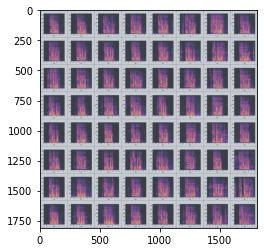

In [12]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
images_train, labels_train = next(iter(ravdess_train_loader))  
images_test, labels_test = next(iter(ravdess_test_loader))
images_valid, labels_valid = next(iter(ravdess_valid_loader))
print("Train Labels:",labels_train)

imshow(torchvision.utils.make_grid(images_valid)/ 4)

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [13]:
def model_res():
    device = "cpu"
    spec_resnet = models.resnet50(pretrained=True)

    for param in spec_resnet.parameters():
        param.requires_grad = False

        spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(), nn.Linear(500,8))
        return spec_resnet

### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [14]:
device = "cpu"
spec_resnet = model_res()
spec_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Text(0.5, 0, 'Lernrate')

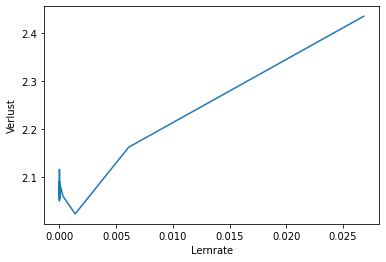

In [18]:
#Die Lernrate 
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "spec_resnet_temp.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=0.001)
logs,losses = find_lr(spec_resnet, loss_fn, optimizer, ravdess_train_loader, device=device)
plt.plot(logs, losses)
plt.ylabel('Verlust')
plt.xlabel('Lernrate')

### Modell-Training<a class="anchor" id="#modelltraining"></a>

In [ ]:
spec_resnet.load_state_dict(torch.load("spec_resnet_temp.pth"))

optimizer = optim.Adam(spec_resnet.parameters(), lr=1e-3)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_valid_loader, epochs = 5, device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-4}
                        ], lr=1e-3)
train(spec_resnet, optimizer, nn.CrossEntropyLoss(), ravdess_train_loader, ravdess_valid_loader,  device=device)
torch.save(spec_resnet.state_dict(),"pth_model_train.pth")

Epoch: 1, Training Loss: 1.76, Validation Loss: 13.47, accuracy = 0.24
Epoch: 2, Training Loss: 1.41, Validation Loss: 6.99, accuracy = 0.37
Epoch: 3, Training Loss: 1.10, Validation Loss: 5.28, accuracy = 0.23
Epoch: 4, Training Loss: 0.95, Validation Loss: 2.79, accuracy = 0.44
Epoch: 5, Training Loss: 0.91, Validation Loss: 1.35, accuracy = 0.56
Epoch: 1, Training Loss: 0.63, Validation Loss: 1.11, accuracy = 0.58
Epoch: 2, Training Loss: 0.44, Validation Loss: 0.98, accuracy = 0.67
Epoch: 3, Training Loss: 0.35, Validation Loss: 1.53, accuracy = 0.52
Epoch: 4, Training Loss: 0.23, Validation Loss: 0.92, accuracy = 0.71


#### Die Genauigkeit des Modells<a class="anchor" id="Genauigkeit"></a>

In [17]:
def prep(loader,model):
    correct = 0
    total = 0
    with torch.no_grad():
    
    # Iterate over the test set
        for data in loader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
        
        # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print('Die Genauigkeit: %d %%' % (100 * correct / total))

In [18]:
# Trainigesdaten
prep(ravdess_train_loader,spec_resnet)

Die Genauigkeit: 96 %


In [19]:
# Testsdaten
prep(ravdess_valid_loader,spec_resnet)

Die Genauigkeit: 69 %


#### Metrics

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
spec_resnet_prod = model_res()
spec_resnet_prod.load_state_dict(torch.load("pth_model_train.pth"))

<All keys matched successfully>

In [22]:
ravdess_train, ravdess_test, _ = LoadRavdess(1000)

In [23]:
img_train, label_train = next(iter(ravdess_train))
img_test, label_test = next(iter(ravdess_test))
label_train.shape,label_train.shape,label_test.shape,label_test.shape

(torch.Size([918]), torch.Size([918]), torch.Size([279]), torch.Size([279]))

### Aufteilung auf die Blocken

### Trainingsdaten

In [24]:
def transform(loader,model):
    device = "cpu"
    with torch.no_grad():
        
        for data in loader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
        
            # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)
            
         
            return labels,predicted


In [25]:
load_train1  = torch.utils.data.Subset(ravdess_train.dataset, range(0, 51-1))
load_train2 = torch.utils.data.Subset(ravdess_train.dataset, range(50, 101-1))
load_train3 = torch.utils.data.Subset(ravdess_train.dataset, range(100, 151-1))
load_train4 = torch.utils.data.Subset(ravdess_train.dataset, range(150, 201-1))
load_train5  = torch.utils.data.Subset(ravdess_train.dataset, range(200, 251-1))
load_train6 = torch.utils.data.Subset(ravdess_train.dataset, range(250, 301-1))
load_train7 = torch.utils.data.Subset(ravdess_train.dataset, range(300, 351-1))
load_train8  = torch.utils.data.Subset(ravdess_train.dataset, range(350, 401-1))
load_train9 = torch.utils.data.Subset(ravdess_train.dataset, range(400, 451-1))
load_train10 = torch.utils.data.Subset(ravdess_train.dataset, range(450, 501-1))
load_train11  = torch.utils.data.Subset(ravdess_train.dataset, range(500, 551-1))
load_train12 = torch.utils.data.Subset(ravdess_train.dataset, range(550, 601-1))
load_train13 = torch.utils.data.Subset(ravdess_train.dataset, range(600, 651-1))
load_train14 = torch.utils.data.Subset(ravdess_train.dataset, range(650, 701-1))
load_train15  = torch.utils.data.Subset(ravdess_train.dataset, range(700, 751-1))
load_train16 = torch.utils.data.Subset(ravdess_train.dataset, range(750, 801-1))
load_train17 = torch.utils.data.Subset(ravdess_train.dataset, range(800, 851-1))
load_train18 = torch.utils.data.Subset(ravdess_train.dataset, range(850, 918))
Dataload_train1 = DataLoader(load_train1, 50)
Dataload_train2 = DataLoader(load_train2, 50 )
Dataload_train3 = DataLoader(load_train3, 50 )
Dataload_train4 = DataLoader(load_train4, 50)
Dataload_train5 = DataLoader(load_train5, 50 )
Dataload_train6 = DataLoader(load_train6, 50 )
Dataload_train7 = DataLoader(load_train7, 50)
Dataload_train8 = DataLoader(load_train8, 50 )
Dataload_train9 = DataLoader(load_train9, 50 )
Dataload_train10 = DataLoader(load_train10, 50)
Dataload_train11 = DataLoader(load_train11, 50 )
Dataload_train12 = DataLoader(load_train12, 50 )
Dataload_train13 = DataLoader(load_train13, 50)
Dataload_train14 = DataLoader(load_train14, 50 )
Dataload_train15 = DataLoader(load_train15, 50 )
Dataload_train16 = DataLoader(load_train16, 50 )
Dataload_train17 = DataLoader(load_train17, 50 )
Dataload_train18 = DataLoader(load_train18, 68)
labels_train1, predicted_train1 = transform(Dataload_train1,spec_resnet_prod)
labels_train2, predicted_train2 = transform(Dataload_train2,spec_resnet_prod)
labels_train3, predicted_train3 = transform(Dataload_train3,spec_resnet_prod)
labels_train4, predicted_train4 = transform(Dataload_train4,spec_resnet_prod)
labels_train5, predicted_train5 = transform(Dataload_train5,spec_resnet_prod)
labels_train6, predicted_train6 = transform(Dataload_train6,spec_resnet_prod)
labels_train7, predicted_train7 = transform(Dataload_train7,spec_resnet_prod)
labels_train8, predicted_train8 = transform(Dataload_train8,spec_resnet_prod)
labels_train9, predicted_train9 = transform(Dataload_train9,spec_resnet_prod)
labels_train10, predicted_train10 = transform(Dataload_train10,spec_resnet_prod)
labels_train11, predicted_train11 = transform(Dataload_train11,spec_resnet_prod)
labels_train12, predicted_train12 = transform(Dataload_train12,spec_resnet_prod)
labels_train13, predicted_train13 = transform(Dataload_train13,spec_resnet_prod)
labels_train14, predicted_train14 = transform(Dataload_train14,spec_resnet_prod)
labels_train15, predicted_train15 = transform(Dataload_train15,spec_resnet_prod)
labels_train16, predicted_train16 = transform(Dataload_train16,spec_resnet_prod)
labels_train17, predicted_train17 = transform(Dataload_train17,spec_resnet_prod)
labels_train18, predicted_train18 = transform(Dataload_train18,spec_resnet_prod)

labels_train = torch.cat([labels_train1, labels_train2,labels_train3,labels_train4, labels_train5,labels_train6,
                        labels_train7, labels_train8,labels_train9,labels_train10,labels_train11,
                        labels_train12, labels_train13,labels_train14, labels_train15,labels_train16, labels_train17,labels_train18])
predicted_train = torch.cat([predicted_train1, predicted_train2,predicted_train3,predicted_train4, predicted_train5,predicted_train6,
                           predicted_train7, predicted_train8,predicted_train9, predicted_train10,predicted_train11,predicted_train12, predicted_train13,predicted_train14,
                           predicted_train15, predicted_train16,predicted_train17, predicted_train18])
labels_train.shape,predicted_train.shape

(torch.Size([918]), torch.Size([918]))

### Confusion Matrix (Trainingsdaten)

              precision    recall  f1-score   support

           0       0.14      0.12      0.13       123
           1       0.16      0.09      0.12        64
           2       0.20      0.08      0.11       118
           3       0.19      0.32      0.24       125
           4       0.19      0.39      0.26       121
           5       0.15      0.11      0.13       124
           6       0.22      0.15      0.18       121
           7       0.17      0.13      0.15       122

    accuracy                           0.18       918
   macro avg       0.18      0.17      0.16       918
weighted avg       0.18      0.18      0.17       918

Confusion matrix, without normalization


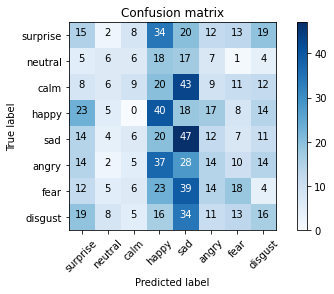

In [26]:
plt.figure()
print(classification_report(labels_train, predicted_train))
plot_confusion_matrix(confusion_matrix(labels_train, predicted_train), classes=class_names)
plt.show()

### Test Daten

In [27]:
load_test1  = torch.utils.data.Subset(ravdess_test.dataset, range(0, 51-1))
load_test2 = torch.utils.data.Subset(ravdess_test.dataset, range(50, 101-1))
load_test3 = torch.utils.data.Subset(ravdess_test.dataset, range(100, 151-1))
load_test4  = torch.utils.data.Subset(ravdess_test.dataset, range(150, 201-1))
load_test5 = torch.utils.data.Subset(ravdess_test.dataset, range(200, 279))
Dataload_test1 = DataLoader(load_test1, 50)
Dataload_test2 = DataLoader(load_test2, 50 )
Dataload_test3 = DataLoader(load_test3, 50 )
Dataload_test4 = DataLoader(load_test4, 50 )
Dataload_test5 = DataLoader(load_test5, 79 )
labels_test1, predicted_test1 = transform(Dataload_test1,spec_resnet_prod)
labels_test2, predicted_test2 = transform(Dataload_test2,spec_resnet_prod)
labels_test3, predicted_test3 = transform(Dataload_test3,spec_resnet_prod)
labels_test4, predicted_test4 = transform(Dataload_test4,spec_resnet_prod)
labels_test5, predicted_test5 = transform(Dataload_test5,spec_resnet_prod)
labels_test = torch.cat([labels_test1, labels_test2,labels_test3,labels_test4,labels_test5], dim=0)
predicted_test = torch.cat([predicted_test1, predicted_test2,predicted_test3, predicted_test4,predicted_test5], dim=0)
labels_test.shape,predicted_test.shape

(torch.Size([279]), torch.Size([279]))

### Confusion Matrix (TestDaten)

              precision    recall  f1-score   support

           0       0.26      0.18      0.22        38
           1       0.29      0.25      0.27        16
           2       0.29      0.12      0.17        43
           3       0.25      0.43      0.31        35
           4       0.33      0.50      0.40        38
           5       0.36      0.38      0.37        34
           6       0.25      0.26      0.26        38
           7       0.42      0.30      0.35        37

    accuracy                           0.30       279
   macro avg       0.31      0.30      0.29       279
weighted avg       0.31      0.30      0.29       279

Confusion matrix, without normalization


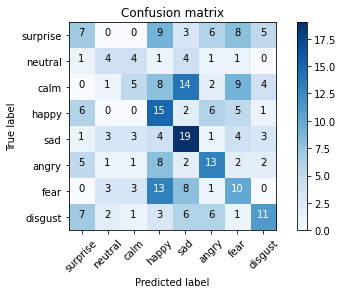

In [28]:
plt.figure()
print(classification_report(labels_test, predicted_test))
plot_confusion_matrix(confusion_matrix(labels_test, predicted_test), classes=class_names)
plt.show()